# Deep Learning - Proyecto Final

## Predicción de Tiempo de recorrido en actividades de Trail Running

## Procesamiento de Datos

La lógica de procesamiento de datos se encuentra implementada en la clase `DataProcessor` dentro del archivo [data_processor.py](utils/data_processor.py). El dispositivo de registro es un reloj Polar Vantage V. Los datos de Polar se encuentran estructurados en formato JSON por lo que es importante poder pasarlos a un formato tabular antes de su procesamiento en el modelo.

El procesamiento de estos datos consiste en extraer y transformar información de archivos JSON que contienen registros de actividades de trail running. El script filtra las actividades por tipo de deporte (TRAIL_RUNNING) y duración (entre 4 y 6 horas). Para cada actividad válida, se extraen muestras de sensores como frecuencia cardíaca, altitud, distancia, temperatura, cadencia y velocidad.

Las muestras se organizan en un DataFrame, donde se realizan varias tareas de ingeniería de características:

Distancia: Se calcula la diferencia entre muestras consecutivas para obtener el avance por intervalo.
Altitud: Se suavizan los datos y se calculan diferencias de elevación, ganancia y pérdida acumulada.
Duración: Se calcula el tiempo acumulado entre muestras.

El procesamiento se realiza de forma eficiente, permitiendo el uso de múltiples hilos para acelerar la conversión de archivos. Los datos procesados se guardan en archivos CSV estructurados, listos para su análisis y modelado.

### Remuestreo

El objetivo del proyecto es realizar una predicción del tiempo por lo que se hizo un remuestreo de los datos para que las muestras estén a intervalos constantes de distancia. La lógica del remuestreo se encuentra en la clase `DataResampler` en el archivo [data_resampling.py](./utils/data_resampling.py).

Se tomaron los archivos de datos de actividades del paso anterior y se los transformó para que las muestras estén espaciadas a intervalos constantes de distancia (cada 2 metros). El proceso incluyó:

- Carga de los datos y conversión de la columna de tiempo a formato datetime. 
- Relleno de valores faltantes en las variables de frecuencia cardíaca, cadencia, velocidad y distancia usando el promedio o el valor anterior.
- Eliminación de duplicados y creación de un nuevo índice de distancia con pasos de 2 metros.
- Interpolación de los valores para obtener datos continuos en esos intervalos.
- Almacenamiento de los archivos remuestreados en formato CSV en una carpeta de salida.


### Análisis Exploratorio de Datos

In [1]:
# Import requiered libraries
import pandas as pd
import matplotlib.pyplot as plt
import os
import random

# Define the directory containing the processed data
data_dir = "./data/resampled"
# Get the training files list
training_files=os.listdir(data_dir)

# Get the files count
print(f"Number of training files: {len(training_files)}")

Number of training files: 106


In [2]:
# Load and process all CSV files
data_frames = []
for file_name in training_files:
    file_path = os.path.join(data_dir, file_name)
    df = pd.read_csv(file_path)
    data_frames.append(df)

# Combine all data
data = pd.concat(data_frames, ignore_index=True)

# Display basic information about the dataset
print(data.info())

# Display summary statistics
print(data.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 465939 entries, 0 to 465938
Data columns (total 16 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   distance            465939 non-null  float64
 1   timestamp           465939 non-null  object 
 2   heartRate           465939 non-null  float64
 3   duration            465939 non-null  float64
 4   altitude            465939 non-null  float64
 5   distance_diff       465939 non-null  float64
 6   temperature         465939 non-null  float64
 7   cadence             465939 non-null  float64
 8   speed               465939 non-null  float64
 9   elevation_diff      465939 non-null  float64
 10  elevation_gain      465939 non-null  float64
 11  elevation_loss      465939 non-null  float64
 12  duration_diff       465939 non-null  float64
 13  session_id          465939 non-null  object 
 14  time_idx            465939 non-null  int64  
 15  session_id_encoded  465939 non-nul

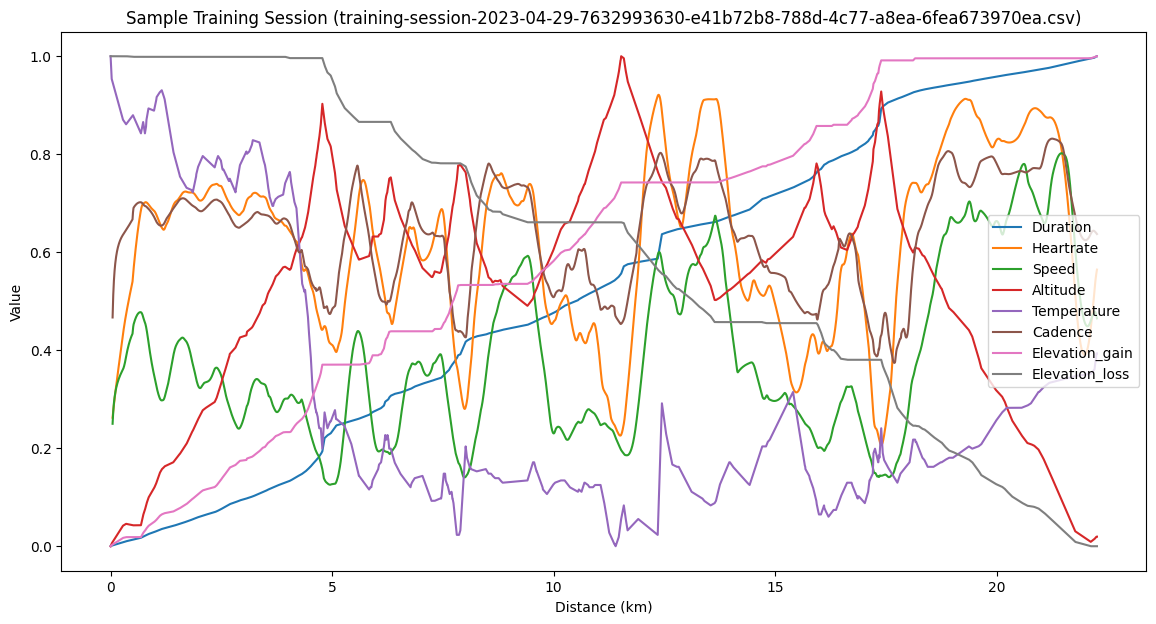

In [3]:
# Plot heart rate over distance
random.seed(4242)
sample_file = random.choice(training_files)
sample_path = os.path.join(data_dir, sample_file)
sample_data = pd.read_csv(sample_path)

#Normalize sample data (scale between 0 and 1 for better visualization)
normalized_cols = {}
for col in ['duration', 'heartRate', 'speed', 'altitude', 'temperature', 'cadence', 'elevation_gain', 'elevation_loss']:
    normalized_cols[col] = (sample_data[col] - sample_data[col].min()) / (sample_data[col].max() - sample_data[col].min())

# Smooth speed data using rolling average for visualization
normalized_cols['speed'] = normalized_cols['speed'].rolling(window=100, min_periods=10).mean()
normalized_cols['heartRate'] = normalized_cols['heartRate'].rolling(window=100, min_periods=10).mean()
normalized_cols['cadence'] = normalized_cols['cadence'].rolling(window=100, min_periods=10).mean()

plt.figure(figsize=(14, 7))
distance_km = sample_data['distance'] / 1000
for col in normalized_cols:
    plt.plot(distance_km, normalized_cols[col], label=col.capitalize())

plt.xlabel('Distance (km)')
plt.ylabel('Value')
plt.title(f'Sample Training Session ({sample_file})')
plt.legend()
plt.show()


A simple vista se puede observar ciertas correlaciones entre algunas de las variables. El modelo se encargará de hacer la selección de las variables más apropiadas para el caso

### DataModule

Se implementó la clase `TFTDataModule` usando `LightningDataModule` de PyTorch Lightning y la clase `TimeSeriesDataSet` de la libreria `pytorch forecasting` específicamente diseñada para trabajar con modelos de series de tiempo.

#### Carga de Datos

El módulo carga los datos automaticamente. La función prepare_data lee todos los datos y realiza algunas operaciones necesarias para integrarla con los módulos de la libreria de `pytorch-forecasting`. Por ejemplo, se agregan session identifiers como variable categorica y se convierte los valores de distance un `time_idx` que es un valor secuencial requerido por `TimeSeriesDataset`

#### División de Datos

Inicialmente se dividieron los datos temporalmente en proporciones 70:15:15 de entrenamiento, validación y test respectivamente, de acuerdo a las recomendaciones para series temporales para prevenir fuga de datos del pasado hacia los pasos de validación y test. Sin embargo el objetivo del proyecto es que el modelo tenga la capacidad de manejar predicciones sobre scenarios cold-start, es decir, el deportista no ha iniciado todavía el recorrido, por lo que se hizo la división basada en sesiones en lugar de divisiones temporales.

La implementación del DataModule incluye además:

- **Normalización por grupos**: Aplica `GroupNormalizer` por sesión para mejor generalización
- **Variables futuras**: Distingue entre variables conocidas y desconocidas en el futuro

**Parámetros configurables relevantes:**
- `max_encoder_length`: Longitud máxima del encoder (por defecto 200 pasos)
- `max_prediction_length`: Horizonte de predicción (por defecto 200 pasos)
- `batch_size`: Tamaño del lote para entrenamiento
- `target`: Variable objetivo a predecir ()

**Variables dependientes conocidas** (disponibles al momento de predicción):
- `altitude`: Altitud
- `elevation_diff`: Diferencia de elevación
- `elevation_gain`: Ganancia de elevación
- `elevation_loss`: Pérdida de elevación  
- `distance`: Distancia recorrida

**Variables dependientes desconocidas**:
- `heartRate`: Frecuencia cardíaca
- `temperature`: Temperatura
- `cadence`: Cadencia
- `speed`: Velocidad
- `duration`: Duración de la actividad

La hipótesis es que el modelo junto con la información apropiada permitirá al modelo TFT aprovechar la información conocida del terreno y la ruta para hacer predicciones muy precisas del tiempo de recorrido.

In [4]:
# Import the TFT DataModule
# import sys
# sys.path.append('./utils')
from lib.data import TFTDataModule

# Create and setup the TFT data module
data_module = TFTDataModule(
    data_dir="./data/resampled",
    min_encoder_length=2,
    max_encoder_length=200,
    max_prediction_length=200,
    batch_size=64,
    num_workers=2,
)

# Setup the data
data_module.setup()


Loading 106 training session files...
Loaded 106 sessions with 465939 total data points
Minimum required sequence length: 400
Valid sessions: 106/106
Session-based splits for cold-start evaluation:
Train sessions: 79, Val sessions: 15, Test sessions: 12
Train data points: 347748, Val: 72019, Test: 46172
Overlap between train-val: 0, train-test: 0
Training samples: 347511
Validation samples: 71974
Test samples: 12


In [5]:
# Get a sample batch to understand the data structure
train_loader = data_module.train_dataloader()
sample_batch = next(iter(train_loader))

print(f"\nBatch structure:")
print(f"Batch type: {type(sample_batch)}")
print(f"Input features shape: {sample_batch[0]['encoder_cont'].shape}")  # [batch_size, encoder_length, features]
print(f"Target length: {len(sample_batch[1][0])}")          # Number of target variables
print(f"Target variable shape: {sample_batch[1][0][2].shape}")    # [batch_size, prediction_length]


Batch structure:
Batch type: <class 'tuple'>
Input features shape: torch.Size([64, 200, 21])
Target length: 5
Target variable shape: torch.Size([64, 200])


## Modelo

### Temporal Fusion Transformer (TFT)

El **Temporal Fusion Transformer** (TFT) es un modelo de deep learning diseñado específicamente para predicción de series temporales que puede manejar tanto variables conocidas como desconocidas en el futuro.

Inicialmente se implementó una arquitectura custom dentro de la clase `TrailRunningTFT` enfocado a predecir el tiempo de recorrido en actividades de trail running como un módulo de *Pytorch Lightning*, instanciando el modelo `TemporalFusionTransformer` de la librería `pytorch-forecasting` dentro de la clase custom. Sin embargo, la clase `TemporalFusionTransformer` ya esta implementada como un módulo de *Pytorch Lightning* por lo que instanciar nuevamente resultó ser innecesario y se procedió a extender la clase para proveer de las customizaciones del caso que puediesen ser aplicadas al dominio especifico de las actividades del Trail Running.

**Características del modelo:**
- **Arquitectura**: Temporal Fusion Transformer optimizado para series temporales (secuenciales)
- **Variables conocidas futuras**: `altitude`, `elevation_diff`, `elevation_gain`, `elevation_loss`, `distance_diff` (disponibles en el momento de la predicción)
- **Variables desconocidas futuras**: `duration`, `heartRate`, `temperature`, `cadence`, `speed` (necesitan ser estimadas)
- **Variable objetivo**: `duration`, `heartRate`, `temperature`, `cadence`, `speed`
- **Longitud de secuencia**: 40-200 pasos temporales de entrada
- **Horizonte de predicción**: 200 pasos hacia el futuro

## Entrenamiento

In [6]:
# # Entrenar el modelo
# import subprocess
# import sys

# # Ejecuta el script de entrenamiento usando subprocess
# script_path = "training.py"

# # Verificar que el script existe
# if not os.path.exists(script_path):
#     print(f"Error: No se encontró el archivo {script_path}")
#     exit(1)

# print("Iniciando entrenamiento del modelo TFT...")

# try:
#     # Ejecutar el script con subprocess
#     process = subprocess.Popen(
#         [sys.executable, script_path],
#         stdout=subprocess.PIPE,
#         stderr=subprocess.STDOUT,
#         universal_newlines=True,
#         bufsize=1
#     )
    
#     # Mostrar la salida en tiempo real
#     for line in process.stdout:
#         print(line.rstrip())
    
#     # Esperar a que termine el proceso
#     process.wait()
    
#     if process.returncode == 0:
#         print("Entrenamiento completado exitosamente!")
#     else:
#         print("\n" + "=" * 60)
#         print(f"Error durante el entrenamiento. Código de salida: {process.returncode}")
        
# except Exception as e:
#     print(f"Error al ejecutar el script: {str(e)}")


📊 Hyperparameters for version_11:
learning_rate            : 0.001
dropout                  : 0.25
hidden_size              : 64
hidden_continuous_size   : 32
attention_head_size      : 4
lstm_layers              : 1
max_encoder_length       : 200
max_prediction_length    : 200
min_encoder_length       : 2
weight_decay             : 0.005
causal_attention         : True
optimizer                : adam
reduce_on_plateau_patience: 4
reduce_on_plateau_min_lr : 1.0e-05
reduce_on_plateau_reduction: 2.0
predict_mode             : False
Total Sequence Length    : 400 (200 encoder + 200 prediction)
target_variables         : duration, heartRate, temperature, cadence, speed


Plotting metrics for version_11...


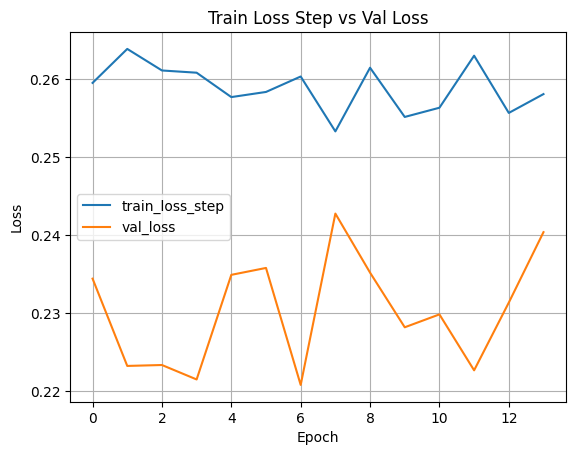


📊 Hyperparameters for version_12:
learning_rate            : 0.001
dropout                  : 0.25
hidden_size              : 64
hidden_continuous_size   : 32
attention_head_size      : 4
lstm_layers              : 1
max_encoder_length       : 200
max_prediction_length    : 200
min_encoder_length       : 2
weight_decay             : 0.005
causal_attention         : True
optimizer                : adam
reduce_on_plateau_patience: 4
reduce_on_plateau_min_lr : 1.0e-05
reduce_on_plateau_reduction: 2.0
predict_mode             : False
Total Sequence Length    : 400 (200 encoder + 200 prediction)
target_variables         : duration, heartRate, temperature, cadence, speed


Plotting metrics for version_12...


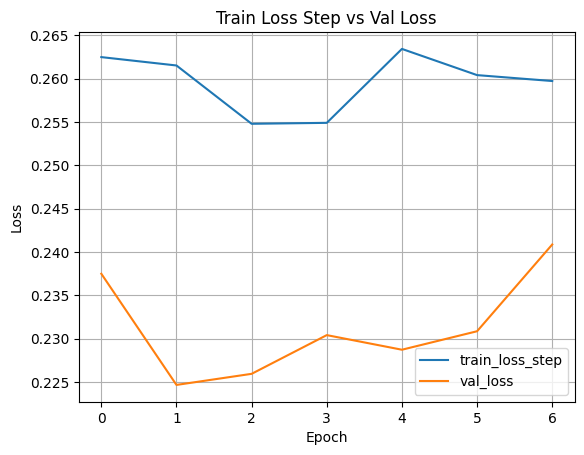


📊 Hyperparameters for version_13:
learning_rate            : 0.0005
dropout                  : 0.25
hidden_size              : 64
hidden_continuous_size   : 32
attention_head_size      : 4
lstm_layers              : 1
max_encoder_length       : 200
max_prediction_length    : 200
min_encoder_length       : 2
weight_decay             : 0.005
causal_attention         : True
optimizer                : adam
reduce_on_plateau_patience: 4
reduce_on_plateau_min_lr : 1.0e-05
reduce_on_plateau_reduction: 2.0
predict_mode             : False
Total Sequence Length    : 400 (200 encoder + 200 prediction)
target_variables         : duration, heartRate, temperature, cadence, speed


Plotting metrics for version_13...


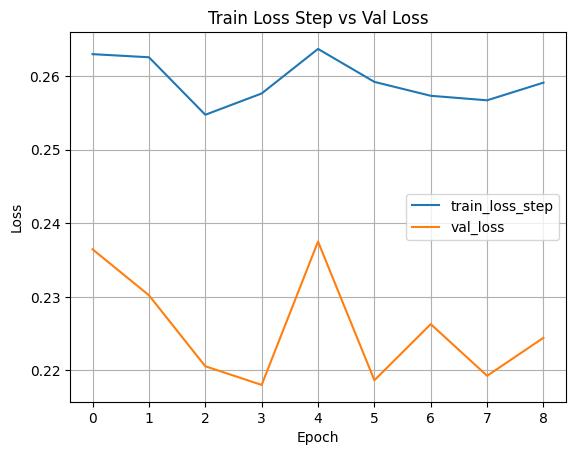

In [7]:
import os
import importlib
# reload utils.viz to ensure latest changes are used
import utils.viz
importlib.reload(utils.viz)
from utils.viz import plot_metrics, extract_hparams

# Plot training and validation loss and extract hyperparameters
logs_dir = "./logs/tft_model/"
# for version in sorted(os.listdir(logs_dir)):
# for version in ['version_2', 'version_4', 'version_6', 'version_7', 'version_8', 'version_9']:
for version in ['version_11', 'version_12', 'version_13']:
    version_path = os.path.join(logs_dir, version)
    if not os.path.isdir(version_path):
        continue
    metrics_file = os.path.join(version_path, "metrics.csv")
    hparams_file = os.path.join(version_path, "hparams.yaml")
    
    # Extract and display hyperparameters (if they exist)
    if os.path.exists(hparams_file):
        print(f"\n📊 Hyperparameters for {version}:")
        print("=" * 50)
        
        try:
            params = extract_hparams(hparams_file)
            
            # Define the parameters we're interested in
            key_params = [
                'learning_rate',
                'dropout',
                'hidden_size',
                'hidden_continuous_size',
                'attention_head_size',
                'lstm_layers',
                'max_encoder_length',
                'max_prediction_length',
                'min_encoder_length',
                'weight_decay',
                'causal_attention',
                'optimizer',
                'reduce_on_plateau_patience',
                'reduce_on_plateau_min_lr',
                'reduce_on_plateau_reduction',
                'randomize_length',
                'predict_mode',
            ]
            
            # Display found parameters
            for param in key_params:
                if param in params:
                    print(f"{param:25}: {params[param]}")
            
            # Calculate and display total sequence length
            encoder_len = params.get('max_encoder_length', 'N/A')
            pred_len = params.get('max_prediction_length', 'N/A')
            if isinstance(encoder_len, int) and isinstance(pred_len, int):
                total_len = encoder_len + pred_len
                print(f"{'Total Sequence Length':25}: {total_len} ({encoder_len} encoder + {pred_len} prediction)")
            
            # Display target variables
            if 'target_variables' in params:
                print(f"{'target_variables':25}: {', '.join(params['target_variables'])}")
            
        except Exception as e:
            print(f"Error processing {hparams_file}: {str(e)}")
        
        print("\n" + "=" * 50 + "\n")

    if os.path.exists(metrics_file):
        print(f"Plotting metrics for {version}...")
        plot_metrics(
            metrics_file,
            plot_metrics=[["train_loss_step", "val_loss"]],
            # save_svg_path=os.path.join("./assets/", f"loss_plot_{version}.svg")
        )

## Análisis de Overfitting

Uno de los objetivos fue reducir el overfitting manteniendo la capacidad predictiva del modelo. Del análisis de las métricas de los entrenamientos iniciales se observó un claro overfitting. Se identificaron algunas posibles causas:

### Tamaño y diversidad del dataset en comparación a la complejidad del modelo

El problema principal en este caso es que se limitó el numero de muestras por dos motivos: filtrar sesiones de entrenamiento relativamente largas que puedan capturar información de la actividad física de resistencia y limitar el tamaño del dataset para tener un entrenamiento un poco más acelerado. Al mismo tiempo se quería procesar longitudes de secuencia largas para capturar dependencias en ventanas mas grandes, sin embargo, esto al mismo tiempo causa que el modelo tenga más parámetros entrenables y por lo tanto se vuelva mas complejo.

Otro problema, es que muchas de las sesiones tienen condiciones diferentes de las cuales el modelo no tiene conocimiento, algunas de las cuales son:
- No hay distincion entre sensiones de entrenamiento y sesiones de competencia. El RPE (Rate of Perceived Effort) puede ser muy diferente en una competencia que un entrenamiento, usualmente los entrenamientos largos sobre todo se llevan a cabo en su mayoría en un RPE entre 3 y 4 con pequeños intervalos de RPE entre 5 a 8. Mientras que una competencia tiene su mayoria un RPE entre 5 a 8, con periodos de recuperación con RPE entre 2 y 4. Otro problema es que no se esta identificando la ingesta de calorías, hidratación o ayudas ergogénicas que podrían tener un impacto significativo en el desempeño del deportista.

Una solución futura será incluir un mayor numero de muestras en el modelo e incluir etiquetas adicionales a los datos como RPE.

### Balanceo de datos

Un problema identificado fue que la configuración inicial tenia `predict=True` en `TimeSeriesDataSet.from_dataset()` para el set de validación. Esto creaba solo **1 muestra por sesión** para validación. Inicialmente esto parecia normal puesto que la división de datos se hizo basada en las sesiones, pero al comparar con las muestras identificadas por el dataloader para el entrenamiento había un desbalance significativo. Luego de una revisión de la documentación de la libreria se pudo entender mejor el proposito del parametro (https://pytorch-forecasting.readthedocs.io/en/v1.4.0/api/pytorch_forecasting.data.timeseries._timeseries.TimeSeriesDataSet.html#pytorch_forecasting.data.timeseries._timeseries.TimeSeriesDataSet.from_dataset). Se cambió a `predict=False` en los parametros de la creación del dataset para obtener múltiples muestras por sesión.

### Secuencias Muy Largas

Inicialmente se configuró al modelo para tener un encoder de 250 pasos + predicción de 50 pasos = 300 pasos totales, con el fin de tener una longitud que pudiese capturar las dependencias temporales de alta resistencia. Esto al mismo tiempo volvio al modelo muy complejo para el tamaño del dataset. Se probarón algunas combinaciones sin un impacto significativo. Al final, se procedió a reducir el encoder a una longitud de 200 + predicción de 40 = 240 pasos totales

### Falta de Regularización
Inicialmente no se tendía una randomización de la longitud de las secuencias y se tenia un dropout bajo (0.1) Tampoco se habia configurado `weight_decay` para regularización. Se procedió a activar `randomize_length=True`, aumentar dropout a 0.3 y agregar `weight_decay`.

### Predicción Multi-objetivo Compleja
En este caso se tienen 5 variables objetivo simultáneas con 21 características de entrada. Weighted Loss como solucion.



## Evaluación

In [16]:
import torch
import numpy as np
import lightning.pytorch as pl
from lightning.pytorch.loggers import CSVLogger
from training import find_latest_checkpoint
from lib.model import TrailRunningTFT

# Evaluate the model
logger = CSVLogger(
    save_dir="./logs/tft_model/",
    name="tft_evaluation",
    version=0
)

# Load the trainer on the latest checkpoint
trainer = pl.Trainer(
    max_epochs=1,
    accelerator='auto',
    strategy='auto',
    logger=logger,
    devices='auto',
    enable_checkpointing=True,
    precision="32-true",
    callbacks=[]
)

model = TrailRunningTFT.from_dataset(
    data_module.training,
    hidden_size=64,
    learning_rate=0.001,
    output_size=[1] * 5, # Multi-target output 
)

ckpt_path = find_latest_checkpoint()
if (not ckpt_path):
    print("No checkpoint found, cannot evaluate model.")
    exit(1)

print(f"Cargando modelo desde checkpoint: {ckpt_path}")

# Test the model on test dataset
test_results = trainer.test(model, data_module.test_dataloader(), ckpt_path=ckpt_path)


INFO: Trainer will use only 1 of 4 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=4)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
INFO:lightning.pytorch.utilities.rank_zero:Trainer will use only 1 of 4 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=4)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
INFO: 💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
INFO:lightning.pytorch.utilities.rank_zero:💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheck

Initialized MultiLoss with target weights:
  duration: 80.0%
  heartRate: 5.0%
  temperature: 5.0%
  cadence: 5.0%
  speed: 5.0%


INFO: Restoring states from the checkpoint path at ./checkpoints/best-checkpoint-epoch=10-val_loss=0.22.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restoring states from the checkpoint path at ./checkpoints/best-checkpoint-epoch=10-val_loss=0.22.ckpt


Cargando modelo desde checkpoint: ./checkpoints/best-checkpoint-epoch=10-val_loss=0.22.ckpt


INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]
INFO: Loaded model weights from the checkpoint at ./checkpoints/best-checkpoint-epoch=10-val_loss=0.22.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Loaded model weights from the checkpoint at ./checkpoints/best-checkpoint-epoch=10-val_loss=0.22.ckpt


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│     cadence test_MAE      │     9.978601455688477     │
│     cadence test_RMSE     │    10.566987991333008     │
│    cadence test_SMAPE     │    0.13000725209712982    │
│     duration test_MAE     │     2446.121337890625     │
│    duration test_RMSE     │     2860.80810546875      │
│    duration test_SMAPE    │    0.1721944361925125     │
│    heartRate test_MAE     │    17.896711349487305     │
│    heartRate test_RMSE    │     20.18764305114746     │
│   heartRate test_SMAPE    │    0.13056083023548126    │
│      speed test_MAE       │    3.3274331092834473     │
│      speed test_RMSE      │    3.7737717628479004     │
│     speed test_SMAPE      │    0.35667693614959717    │
│   temperature test_MAE    │     5.36759614944458      │
│   temperature test_RMSE   │     6.181943893432617     │
│  temperature test_SMAPE   │    0.3178606331348419     │
│         test_loss         │    0.18451082706451416    │
└───────────────────────────┴───────────────────────────┘

INFO: Trainer will use only 1 of 4 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=4)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
INFO:lightning.pytorch.utilities.rank_zero:Trainer will use only 1 of 4 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=4)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
INFO: 💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
INFO:lightning.pytorch.utilities.rank_zero:💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheck

=== Visualizing Duration (Target 0) for Batch 0 ===


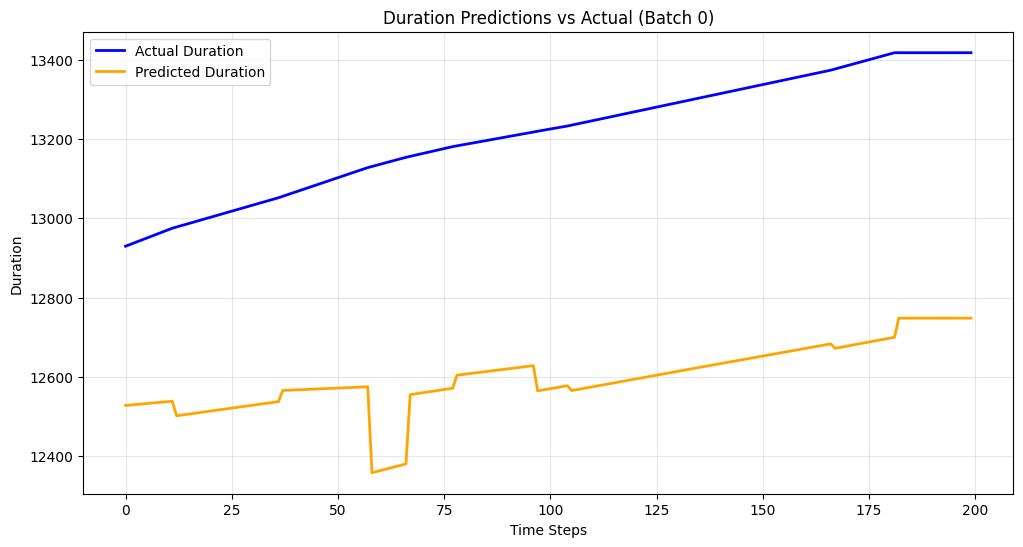


Error Metrics for Duration (Batch 0):
MSE: 388383.0312
MAE: 616.2242
RMSE: 623.2039

=== Visualizing Heart Rate (Target 1) for Batch 0 ===


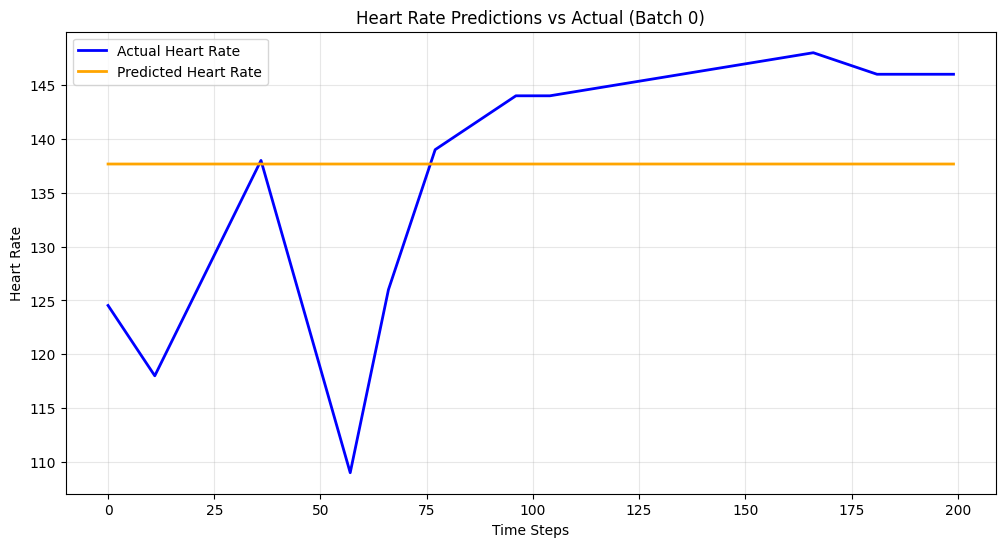


Error Metrics for Heart Rate (Batch 0):
MSE: 119.5399
MAE: 9.5058
RMSE: 10.9334

=== Visualizing Duration (Target 0) for Batch 1 ===


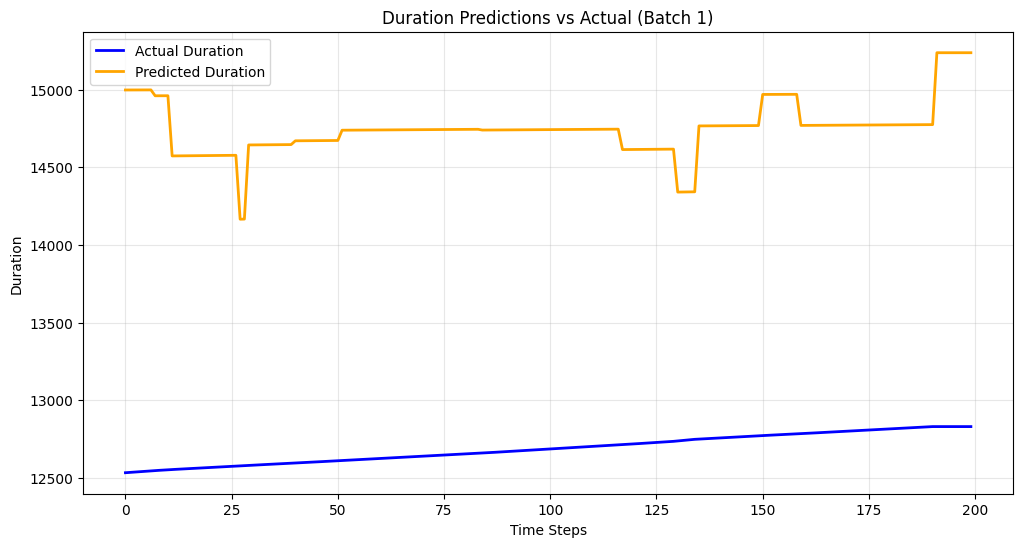


Error Metrics for Duration (Batch 1):
MSE: 4266148.5000
MAE: 2059.1680
RMSE: 2065.4656


In [33]:
import importlib
import utils.viz
importlib.reload(utils.viz)
from utils.viz import visualize_predictions

raw_predictions = model.predict(
    data_module.test_dataloader(), mode="raw", return_x=True
)

# Example usage - visualize different batches and targets
target_names = ["Duration", "Heart Rate", "Temperature", "Cadence", "Speed"]

# Visualize duration for batch 0
print("=== Visualizing Duration (Target 0) for Batch 0 ===")
pred_duration, act_duration = visualize_predictions(raw_predictions, batch_id=0, target_idx=0, target_name="Duration")

# Visualize heart rate for batch 0
print("\n=== Visualizing Heart Rate (Target 1) for Batch 0 ===")
pred_hr, act_hr = visualize_predictions(raw_predictions, batch_id=0, target_idx=1, target_name="Heart Rate")

# If you have multiple batches, visualize a different batch
print("\n=== Visualizing Duration (Target 0) for Batch 1 ===")
try:
    pred_duration_b1, act_duration_b1 = visualize_predictions(raw_predictions, batch_id=1, target_idx=0, target_name="Duration")
except IndexError:
    print("Batch 1 not available (only 1 batch in dataset)")

## Discusión y Conclusiones

## Resumen de la Implementación

### Organización del Código

El código se organizó en dos módulos principales para mayor claridad y mantenibilidad:

**`data_module.py`**:
- Contiene `TFTDataModule`: DataModule especializado para pytorch-forecasting
- Manejo completo de datos desde carga hasta preparación para TFT
- División temporal inteligente dentro de cada sesión
- Configuración automática de variables conocidas/desconocidas

**`model.py`**:
- Contiene `TrailRunningTFT`: Wrapper de Lightning para TemporalFusionTransformer
- Funciones de entrenamiento y utilidades del modelo
- Configuración optimizada para predicción de tiempo en trail running

### TFTDataModule Implementado

Se creó un `TFTDataModule` personalizado que:
- Carga automáticamente todos los archivos CSV de sesiones de trail running
- Implementa división temporal dentro de cada sesión para entrenamiento/validación/prueba
- Normaliza las características usando `GroupNormalizer` por sesión
- Maneja variables conocidas y desconocidas en el futuro según el problema de predicción
- Es totalmente compatible con `pytorch-forecasting` y `TimeSeriesDataSet`

### Modelo TFT Configurado

- **Arquitectura**: Temporal Fusion Transformer optimizado para series temporales multivariadas
- **Variables conocidas futuras**: altitud, diferencias de elevación, distancia (disponibles al momento de predicción)
- **Variables desconocidas**: frecuencia cardíaca, temperatura, cadencia, velocidad
- **Objetivo**: predicción de tiempo (duration)
- **Configuración**: encoder de 30 pasos, predicción de 5 pasos futuros

### Características Técnicas

- Manejo automático de valores faltantes e inconsistencias temporales
- Normalización por grupos (sesiones) para mejor generalización
- División temporal que respeta la naturaleza secuencial de los datos
- Métricas de evaluación: SMAPE, MAE, RMSE
- Interpretabilidad del modelo con análisis de importancia de características

La implementación está lista para entrenar y evaluar la predicción de tiempo en actividades de trail running usando datos de sensores, con una arquitectura de código limpia y modular.